In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, DenseNet121, Xception, MobileNetV2, EfficientNetB0, NASNetMobile, InceptionResNetV2, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

# Global variables
max_images_per_breed = 400  # Number of images per breed
total_epochs = 10  # Number of epochs

# Set directories
base_dir = os.getcwd()
thesis_dir = os.path.abspath(os.path.join(base_dir, ".."))
models_dir = os.path.join(thesis_dir, 'models')
class_indices_path = os.path.join(thesis_dir, 'class_indices.json')
train_dir = os.path.join(thesis_dir, 'images', 'train')
val_dir = os.path.join(thesis_dir, 'images', 'val')

def create_model(model_type, num_classes):
    if model_type == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'inceptionv3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'densenet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'xception':
        base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'mobilenetv2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'efficientnetb0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'nasnetmobile':
        base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'inceptionresnetv2':
        base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'vgg19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    
    return model

def load_image_paths_and_labels(directory, max_images_per_breed):
    image_paths = []
    labels = []
    for breed in os.listdir(directory):
        breed_path = os.path.join(directory, breed)
        if os.path.isdir(breed_path):
            breed_images = os.listdir(breed_path)[:max_images_per_breed]
            for image_name in breed_images:
                image_paths.append(os.path.join(breed_path, image_name))
                labels.append(breed)
    return image_paths, labels

def train(model_type='vgg16'):
    if not os.path.exists(train_dir):
        raise FileNotFoundError(f"Training directory not found: {train_dir}")
    if not os.path.exists(val_dir):
        raise FileNotFoundError(f"Validation directory not found: {val_dir}")
    
    train_image_paths, train_labels = load_image_paths_and_labels(train_dir, max_images_per_breed)
    val_image_paths, val_labels = load_image_paths_and_labels(val_dir, max_images_per_breed)
    
    train_df = pd.DataFrame({'filename': train_image_paths, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_image_paths, 'class': val_labels})
    
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df, x_col='filename', y_col='class', target_size=(224, 224), class_mode='categorical')
    val_generator = val_datagen.flow_from_dataframe(
        val_df, x_col='filename', y_col='class', target_size=(224, 224), class_mode='categorical')
    
    num_classes = len(train_generator.class_indices)
    
    # Save class indices to JSON
    with open(class_indices_path, 'w') as f:
        json.dump(train_generator.class_indices, f)

    # Create and compile the model
    model = create_model(model_type, num_classes)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(train_generator, validation_data=val_generator, epochs=total_epochs)
    
    # Save the model
    model_save_path = os.path.join(models_dir, f'{model_type}.h5')
    model.save(model_save_path)
    print(f"Model saved to: {model_save_path}")
    
    # Plot training and validation accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(total_epochs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()

    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # Generate and display confusion matrix
    val_preds = model.predict(val_generator)
    val_pred_classes = np.argmax(val_preds, axis=1)
    true_classes = val_generator.classes
    cm = confusion_matrix(true_classes, val_pred_classes)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=90)  # Rotate x-axis labels to vertical
    plt.show()


Found 4000 validated image filenames belonging to 10 classes.
Found 3824 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 518s 4s/step - accuracy: 0.2115 - loss: 2.1802 - val_accuracy: 0.4372 - val_loss: 1.6988
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 522s 4s/step - accuracy: 0.5671 - loss: 1.4325 - val_accuracy: 0.5254 - val_loss: 1.4675
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 522s 4s/step - accuracy: 0.6722 - loss: 1.1490 - val_accuracy: 0.5656 - val_loss: 1.3482
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 523s 4s/step - accuracy: 0.7389 - loss: 0.9657 - val_accuracy: 0.6025 - val_loss: 1.2603
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 519s 4s/step - accuracy: 0.8000 - loss: 0.8255 - val_accuracy: 0.5983 - val_loss: 1.2281
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 518s 4s/step - accuracy: 0.8445 - loss: 0.7219 - val_accuracy: 0.5978 - val_loss: 1.2107
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 518s 4s/step - accuracy: 0.8662 - loss: 0.6514 - val_accuracy: 0.6083 - val_loss: 1.1694
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 518s 4s/step - accuracy: 0.8935 - loss: 0.5659 - val_accuracy: 0.619

Model saved to: C:\Users\josej\Thesis\models\vgg16.h5


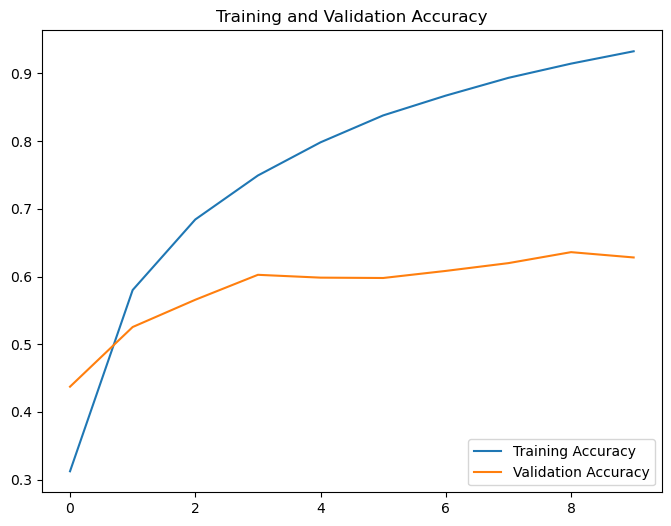

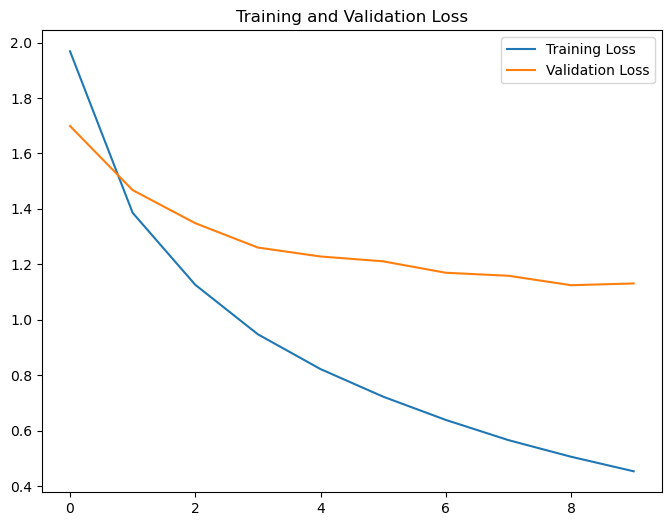

120/120 ━━━━━━━━━━━━━━━━━━━━ 253s 2s/step


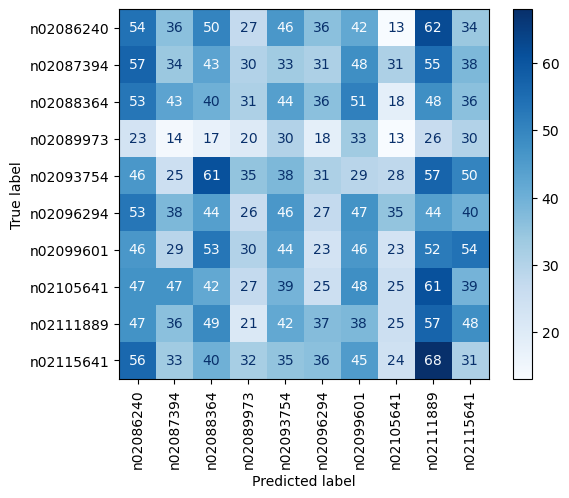

In [2]:
train('vgg16')

Found 4000 validated image filenames belonging to 10 classes.
Found 3824 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.1219 - loss: 2.4426 - val_accuracy: 0.1556 - val_loss: 2.2789
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.1843 - loss: 2.2406 - val_accuracy: 0.2113 - val_loss: 2.2137
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.2194 - loss: 2.1849 - val_accuracy: 0.2150 - val_loss: 2.2165
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.2488 - loss: 2.1074 - val_accuracy: 0.1885 - val_loss: 2.2337
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.2550 - loss: 2.0803 - val_accuracy: 0.1959 - val_loss: 2.1770
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.2490 - loss: 2.0724 - val_accuracy: 0.2340 - val_loss: 2.2132
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.2804 - loss: 2.0231 - val_accuracy: 0.2398 - val_loss: 2.1852
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.3112 - loss: 1.9682 - val_accuracy: 0.178

Model saved to: C:\Users\josej\Thesis\models\resnet50.h5


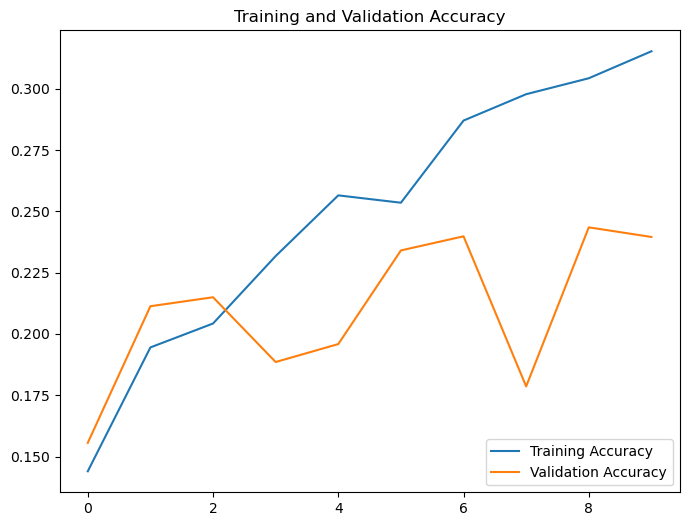

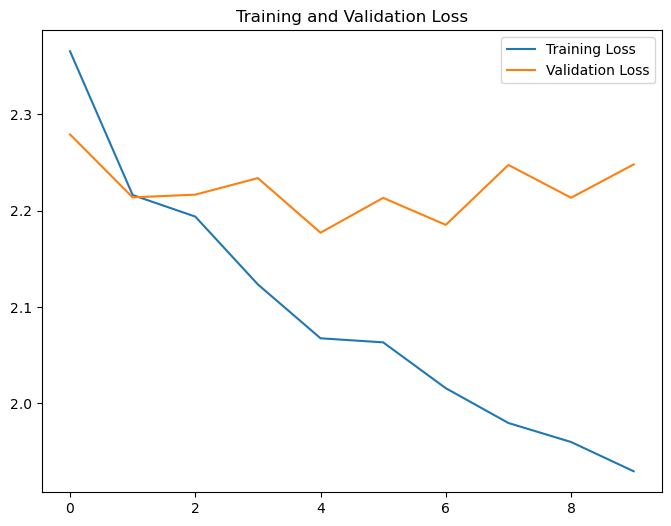

120/120 ━━━━━━━━━━━━━━━━━━━━ 98s 804ms/step


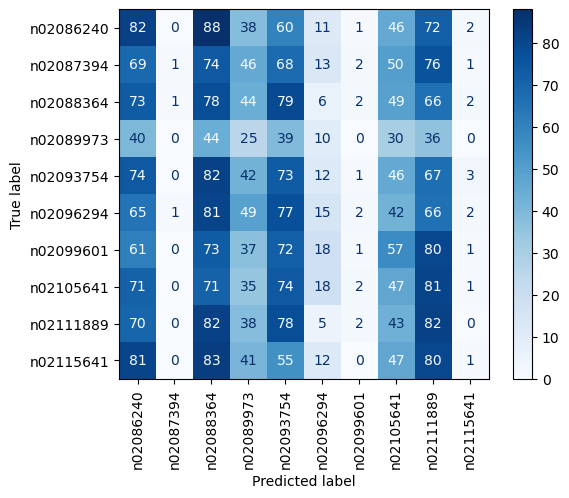

In [3]:
train('resnet50')

Found 4000 validated image filenames belonging to 10 classes.
Found 3824 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 127s 978ms/step - accuracy: 0.7854 - loss: 0.7056 - val_accuracy: 0.9116 - val_loss: 0.3296
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 121s 967ms/step - accuracy: 0.9741 - loss: 0.0802 - val_accuracy: 0.9171 - val_loss: 0.2968
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 121s 968ms/step - accuracy: 0.9920 - loss: 0.0264 - val_accuracy: 0.9087 - val_loss: 0.3307
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 121s 967ms/step - accuracy: 0.9968 - loss: 0.0134 - val_accuracy: 0.9281 - val_loss: 0.2714
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 121s 968ms/step - accuracy: 0.9991 - loss: 0.0077 - val_accuracy: 0.9255 - val_loss: 0.2818
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 121s 969ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.9263 - val_loss: 0.2812
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 121s 967ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9281 - val_loss: 0.2792
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 121s 968ms/step - accuracy: 0.9999 - loss: 0.00

Model saved to: C:\Users\josej\Thesis\models\inceptionv3.h5


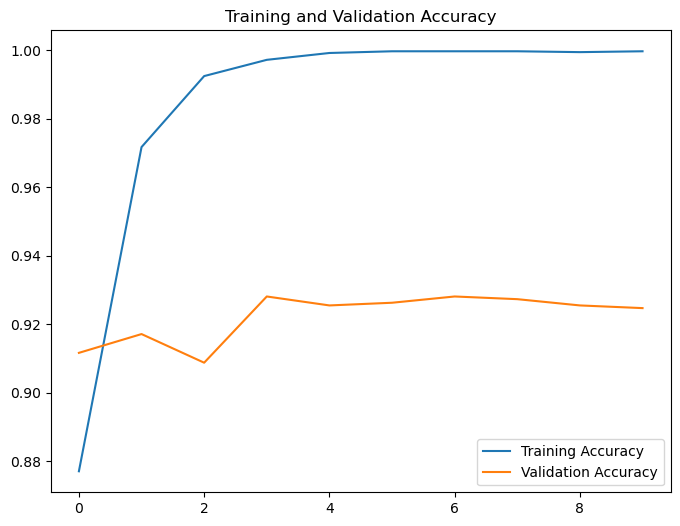

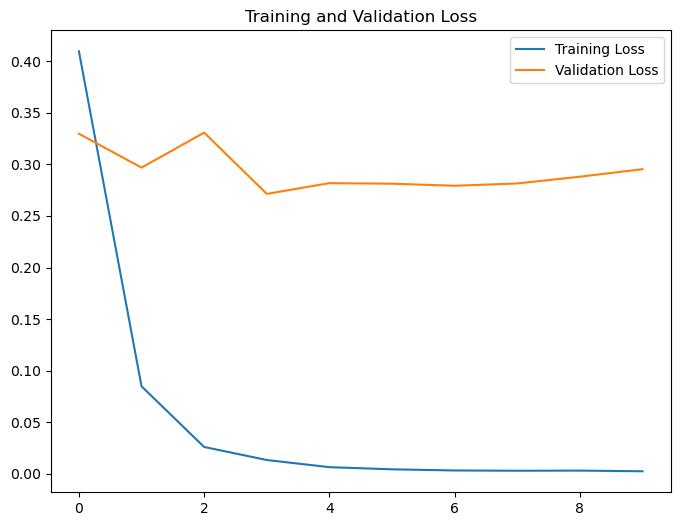

120/120 ━━━━━━━━━━━━━━━━━━━━ 63s 509ms/step


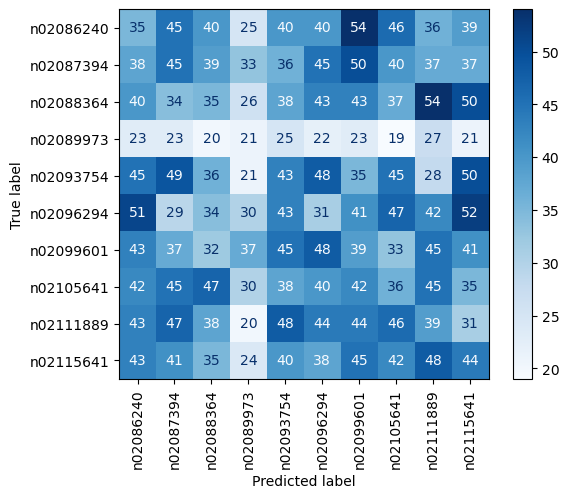

In [4]:
train('inceptionv3')

Found 4000 validated image filenames belonging to 10 classes.
Found 3824 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.8359 - loss: 0.5167 - val_accuracy: 0.9155 - val_loss: 0.3126
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9745 - loss: 0.0723 - val_accuracy: 0.9210 - val_loss: 0.2739
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9925 - loss: 0.0306 - val_accuracy: 0.9289 - val_loss: 0.2601
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.9962 - loss: 0.0146 - val_accuracy: 0.9297 - val_loss: 0.2600
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9989 - loss: 0.0084 - val_accuracy: 0.9291 - val_loss: 0.2634
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.9996 - loss: 0.0056 - val_accuracy: 0.9289 - val_loss: 0.2652
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9995 - loss: 0.0050 - val_accuracy: 0.9291 - val_loss: 0.2647
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.929

Model saved to: C:\Users\josej\Thesis\models\xception.h5


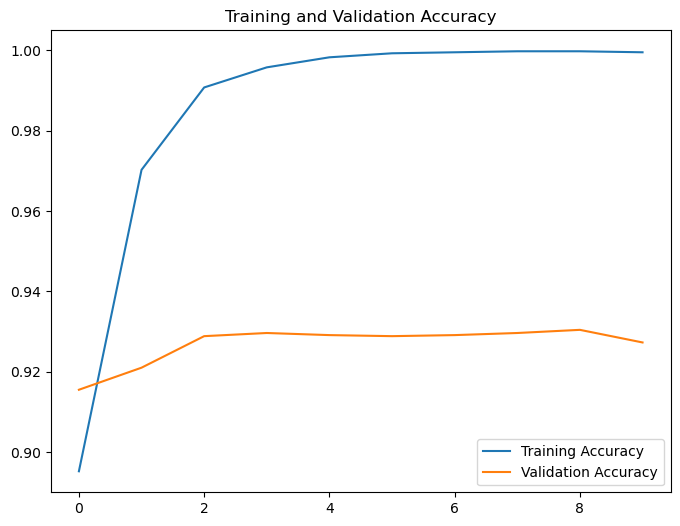

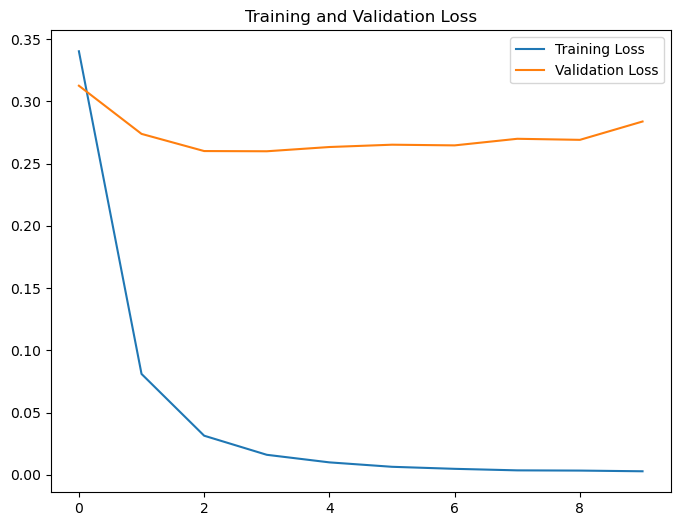

120/120 ━━━━━━━━━━━━━━━━━━━━ 117s 963ms/step


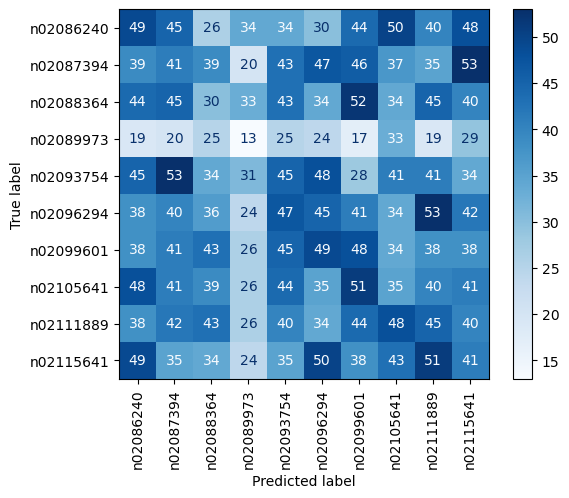

In [5]:
train('xception')

Found 4000 validated image filenames belonging to 10 classes.
Found 3824 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.6551 - loss: 1.2347 - val_accuracy: 0.8556 - val_loss: 0.4865
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.9485 - loss: 0.1496 - val_accuracy: 0.8941 - val_loss: 0.3646
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9925 - loss: 0.0419 - val_accuracy: 0.8985 - val_loss: 0.3603
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.9987 - loss: 0.0186 - val_accuracy: 0.9009 - val_loss: 0.3487
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.9992 - loss: 0.0119 - val_accuracy: 0.8988 - val_loss: 0.3549
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.9999 - loss: 0.0081 - val_accuracy: 0.9030 - val_loss: 0.3489
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.9999 - loss: 0.0061 - val_accuracy: 0.9009 - val_loss: 0.3588
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.9994 - loss: 0.0069 - val_accuracy: 0.903

Model saved to: C:\Users\josej\Thesis\models\densenet121.h5


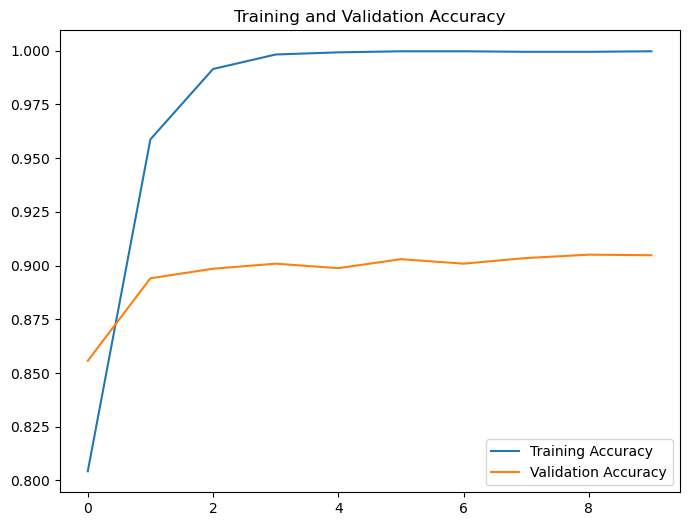

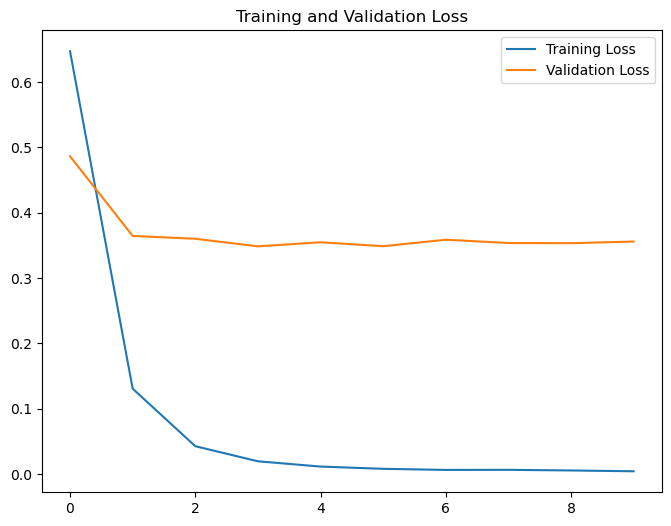

120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 808ms/step


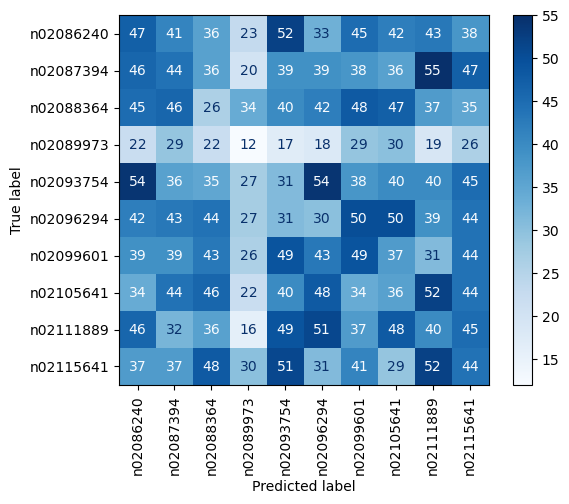

In [6]:
train('densenet121')

Found 4000 validated image filenames belonging to 10 classes.
Found 3824 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 460ms/step - accuracy: 0.7494 - loss: 0.8433 - val_accuracy: 0.8771 - val_loss: 0.4378
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 438ms/step - accuracy: 0.9739 - loss: 0.0718 - val_accuracy: 0.8962 - val_loss: 0.3885
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 438ms/step - accuracy: 0.9987 - loss: 0.0103 - val_accuracy: 0.8964 - val_loss: 0.3814
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 435ms/step - accuracy: 0.9999 - loss: 0.0035 - val_accuracy: 0.9043 - val_loss: 0.3673
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 435ms/step - accuracy: 0.9996 - loss: 0.0043 - val_accuracy: 0.9038 - val_loss: 0.3634
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 435ms/step - accuracy: 0.9999 - loss: 0.0022 - val_accuracy: 0.9069 - val_loss: 0.3601
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 54s 433ms/step - accuracy: 0.9990 - loss: 0.0046 - val_accuracy: 0.9059 - val_loss: 0.3606
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 435ms/step - accuracy: 0.9998 - loss: 0.0015 - val

Model saved to: C:\Users\josej\Thesis\models\mobilenetv2.h5


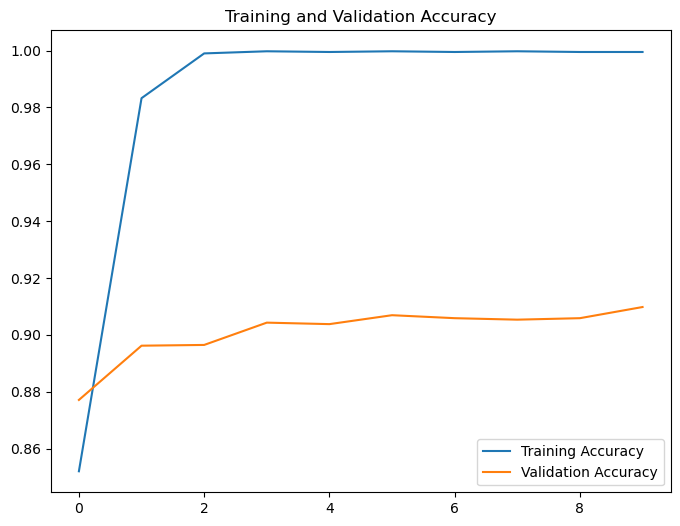

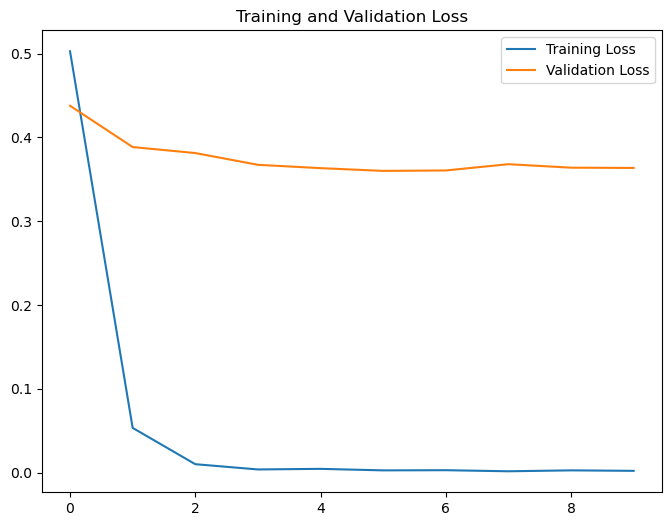

120/120 ━━━━━━━━━━━━━━━━━━━━ 29s 227ms/step


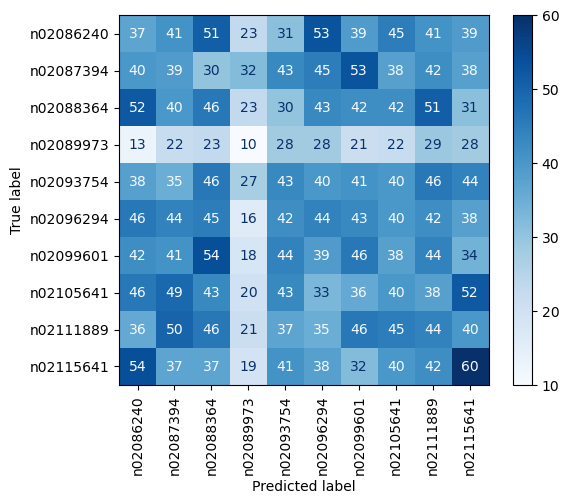

In [7]:
train('mobilenetv2')

Found 4000 validated image filenames belonging to 10 classes.
Found 3824 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 82s 525ms/step - accuracy: 0.8081 - loss: 0.6161 - val_accuracy: 0.9315 - val_loss: 0.2611
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 502ms/step - accuracy: 0.9712 - loss: 0.0735 - val_accuracy: 0.9351 - val_loss: 0.2448
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 503ms/step - accuracy: 0.9955 - loss: 0.0263 - val_accuracy: 0.9336 - val_loss: 0.2649
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 504ms/step - accuracy: 0.9976 - loss: 0.0132 - val_accuracy: 0.9336 - val_loss: 0.2580
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 498ms/step - accuracy: 0.9974 - loss: 0.0098 - val_accuracy: 0.9341 - val_loss: 0.2634
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 503ms/step - accuracy: 0.9980 - loss: 0.0086 - val_accuracy: 0.9388 - val_loss: 0.2540
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 497ms/step - accuracy: 0.9999 - loss: 0.0049 - val_accuracy: 0.9378 - val_loss: 0.2612
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 504ms/step - accuracy: 0.9998 - loss: 0.0038 - val

Model saved to: C:\Users\josej\Thesis\models\nasnetmobile.h5


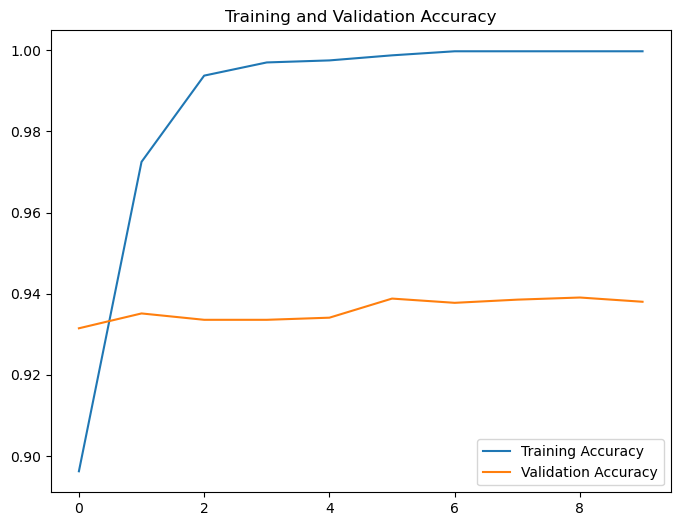

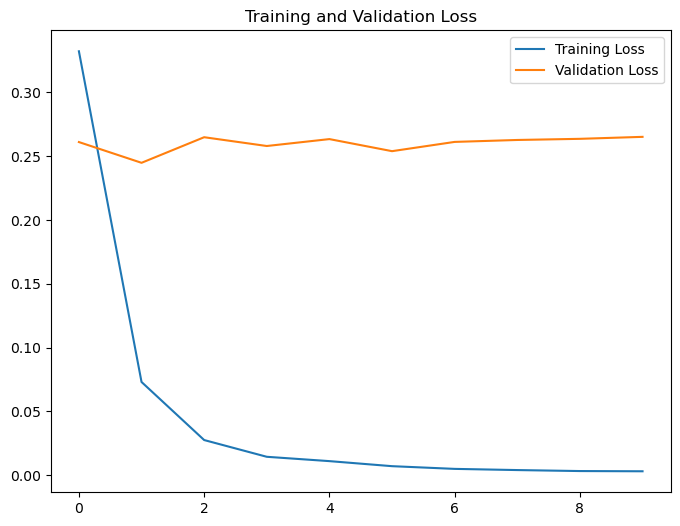

120/120 ━━━━━━━━━━━━━━━━━━━━ 38s 286ms/step


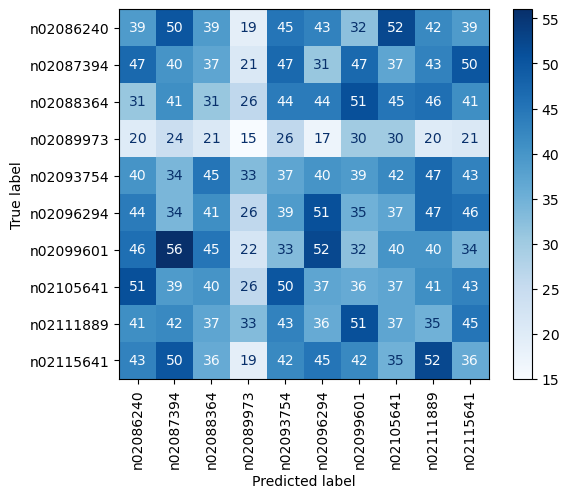

In [8]:
train('nasnetmobile')

Found 4000 validated image filenames belonging to 10 classes.
Found 3824 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 88s 639ms/step - accuracy: 0.1048 - loss: 2.5300 - val_accuracy: 0.1046 - val_loss: 2.4665
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 603ms/step - accuracy: 0.0946 - loss: 2.4142 - val_accuracy: 0.1046 - val_loss: 2.4355
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 604ms/step - accuracy: 0.1018 - loss: 2.4001 - val_accuracy: 0.1046 - val_loss: 2.3158
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 602ms/step - accuracy: 0.0914 - loss: 2.4381 - val_accuracy: 0.1046 - val_loss: 2.5408
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 601ms/step - accuracy: 0.0949 - loss: 2.4076 - val_accuracy: 0.1046 - val_loss: 2.4187
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 603ms/step - accuracy: 0.1058 - loss: 2.4621 - val_accuracy: 0.1046 - val_loss: 2.3462
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 604ms/step - accuracy: 0.0967 - loss: 2.4309 - val_accuracy: 0.1046 - val_loss: 2.4187
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 75s 602ms/step - accuracy: 0.1111 - loss: 2.4434 - val

Model saved to: C:\Users\josej\Thesis\models\efficientnetb0.h5


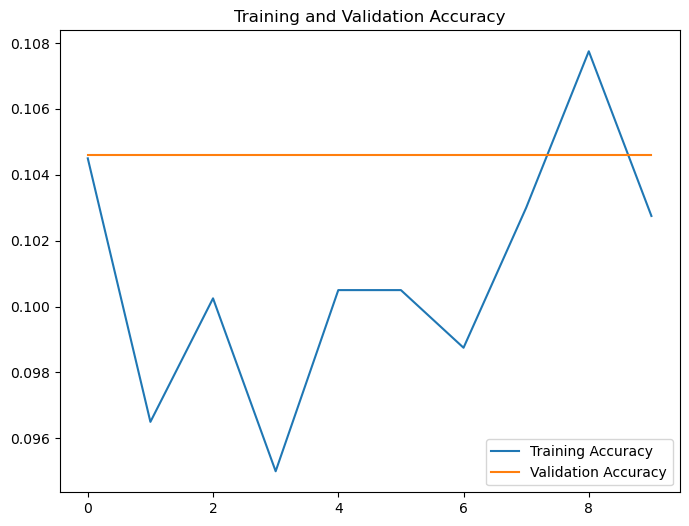

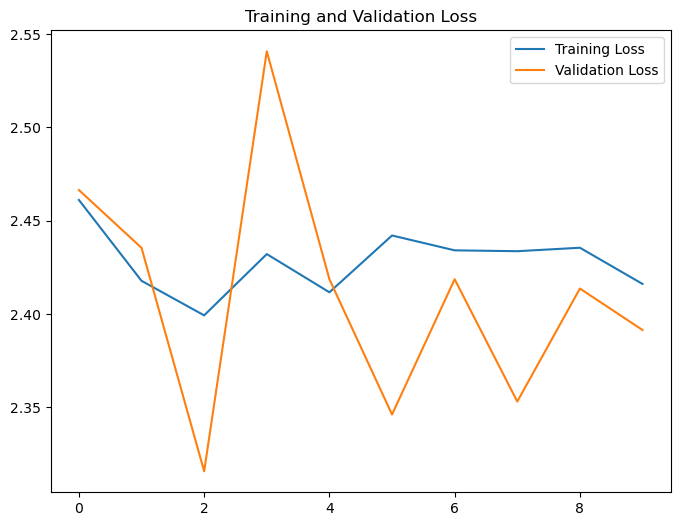

120/120 ━━━━━━━━━━━━━━━━━━━━ 40s 322ms/step


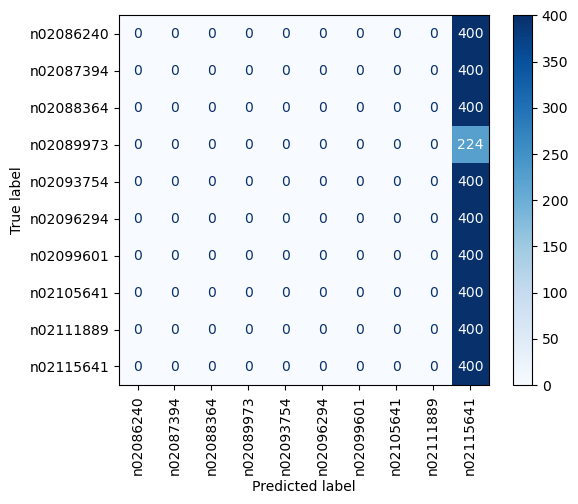

In [9]:
train('efficientnetb0')

Found 4000 validated image filenames belonging to 10 classes.
Found 3824 validated image filenames belonging to 10 classes.



Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 310s 2s/step - accuracy: 0.8065 - loss: 0.6684 - val_accuracy: 0.9260 - val_loss: 0.2981
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.9691 - loss: 0.0863 - val_accuracy: 0.9168 - val_loss: 0.3200
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.9838 - loss: 0.0570 - val_accuracy: 0.9393 - val_loss: 0.2564
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.9936 - loss: 0.0243 - val_accuracy: 0.9218 - val_loss: 0.3139
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.9947 - loss: 0.0155 - val_accuracy: 0.9255 - val_loss: 0.2935
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.9971 - loss: 0.0111 - val_accuracy: 0.9341 - val_loss: 0.2730
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.9997 - loss: 0.0072 - val_accuracy: 0.9299 - val_loss: 0.2911
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.9995 - loss: 0.0050 - val_accuracy: 0.931

Model saved to: C:\Users\josej\Thesis\models\inceptionresnetv2.h5


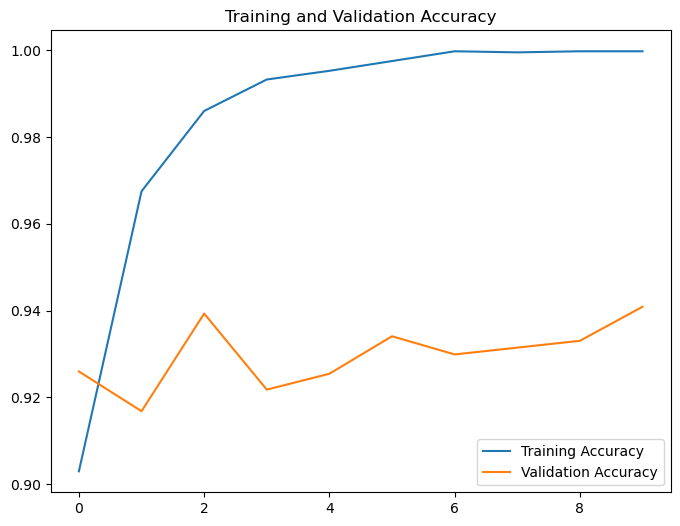

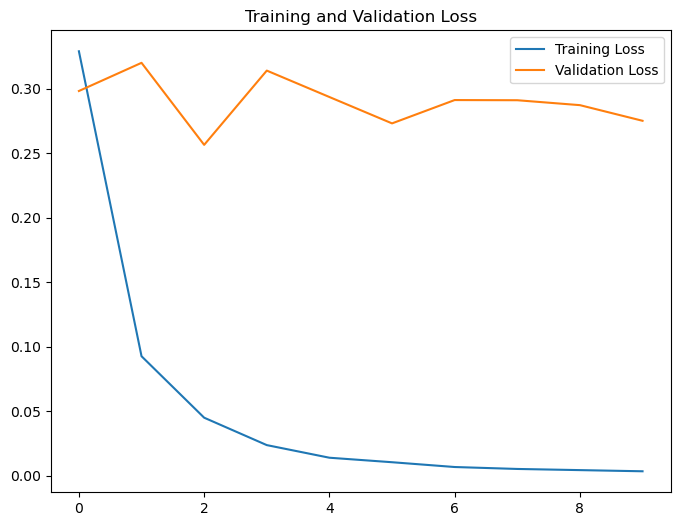

120/120 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step


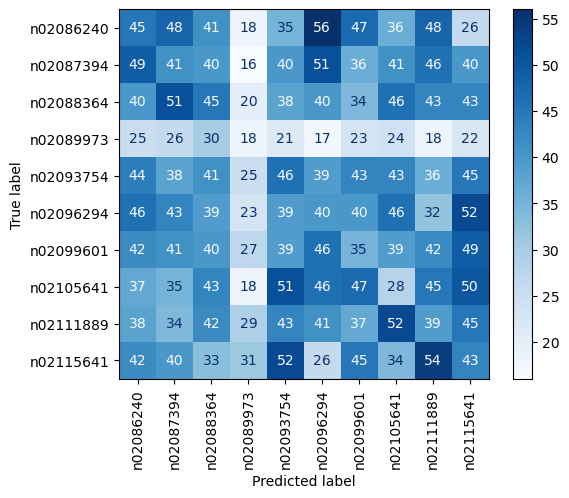

In [10]:
train('inceptionresnetv2')

Found 4000 validated image filenames belonging to 10 classes.
Found 3824 validated image filenames belonging to 10 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 660s 5s/step - accuracy: 0.2254 - loss: 2.1720 - val_accuracy: 0.4145 - val_loss: 1.7411
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 658s 5s/step - accuracy: 0.5414 - loss: 1.5080 - val_accuracy: 0.4759 - val_loss: 1.5358
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 659s 5s/step - accuracy: 0.6317 - loss: 1.2395 - val_accuracy: 0.5272 - val_loss: 1.4185
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 658s 5s/step - accuracy: 0.7073 - loss: 1.0580 - val_accuracy: 0.5463 - val_loss: 1.3638
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 657s 5s/step - accuracy: 0.7670 - loss: 0.9262 - val_accuracy: 0.5633 - val_loss: 1.3002
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 658s 5s/step - accuracy: 0.8047 - loss: 0.8207 - val_accuracy: 0.5560 - val_loss: 1.3083
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 659s 5s/step - accuracy: 0.8294 - loss: 0.7313 - val_accuracy: 0.5758 - val_loss: 1.2494
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 659s 5s/step - accuracy: 0.8576 - loss: 0.6626 - val_accuracy: 0.583

Model saved to: C:\Users\josej\Thesis\models\vgg19.h5


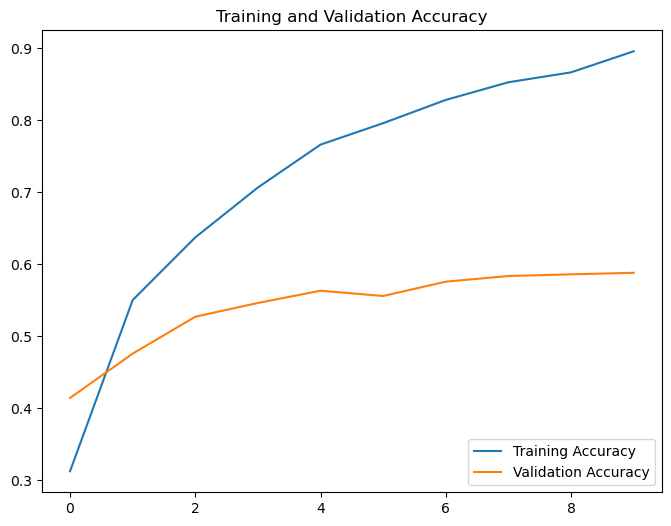

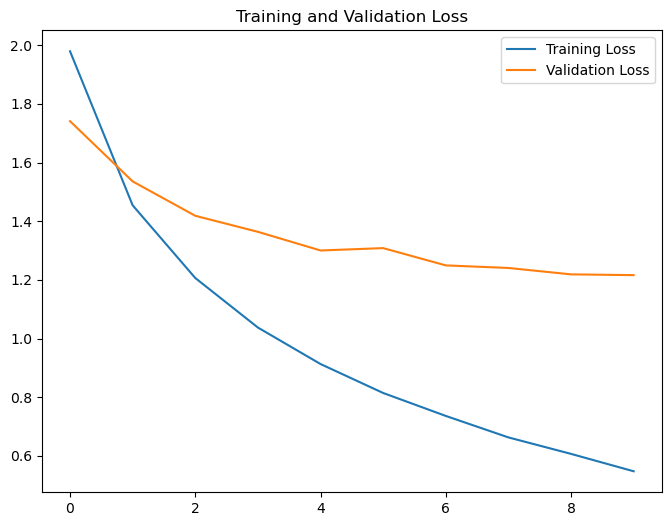

120/120 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step


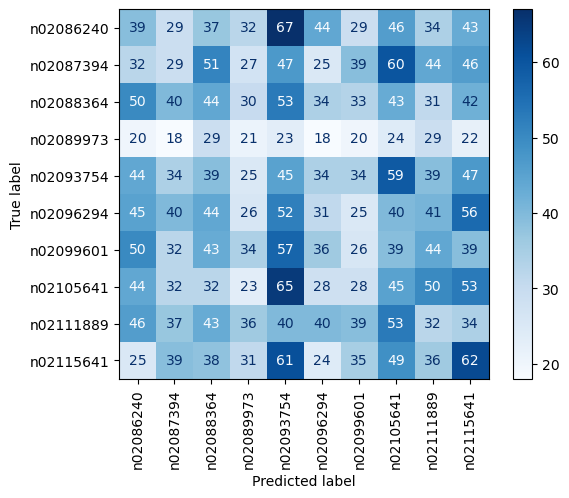

In [11]:
train('vgg19')